<a href="https://colab.research.google.com/github/jcdevaney/TOSS2025/blob/main/toss2025_notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load files from Git repository

In [1]:
!git clone https://github.com/jcdevaney/toss2025.git

Cloning into 'toss2025'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 9), reused 9 (delta 4), pack-reused 73 (from 2)
Receiving objects: 100% (94/94), 58.22 MiB | 8.74 MiB/s, done.
Resolving deltas: 100% (12/12), done.


# Load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

# Functions to plot a spectrogram with an overlay of imported data

In [3]:
def overlayPlot(audiofile,dataDF,title):
    # open audio file
    y, fs = librosa.load(audiofile)

    # run the short time fourier transform
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Create a figure and primary axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Display the spectrogram on the left y-axis
    librosa.display.specshow(D, sr=fs, x_axis='time', y_axis='log')
    ax1.set_ylabel('Spectrogram Power (dB)', color='tab:red')

    # Create a secondary y-axis and plot the time series on it
    ax2 = ax1.twinx()
    ax2.plot(dataDF['Time'], dataDF['Data'], label='Time Series', color='tab:blue')
    ax2.set_ylabel('Energy', color='tab:blue')

    # Add a colorbar for the spectrogram
    cbar = plt.colorbar(format='%+2.0f dB', ax=ax1)
    cbar.set_label('Power (dB)')

    plt.title(title)
    plt.show()

def plotTimePoints(D,sr,times):

  # plot spectrogram
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='mel')

  # Let's draw transparent lines over the beat frames
  plt.vlines(times,
            1, 0.5 * sr,
            colors='w', linestyles='-', linewidth=2, alpha=0.5)

  plt.axis('tight')

  plt.colorbar(format='%+02.0f dB')

  plt.tight_layout()


def plotF0(y,fs,data,plotTitle):

  # generate spectrogram
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

  # plot spectrogram
  fig, ax = plt.subplots()
  img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
  ax.set(title=plotTitle)
  fig.colorbar(img, ax=ax, format="%+2.f dB")

  # overlay data on spectrogram
  ax.plot(data['Time'], data['Data'], label='f0', color='cyan', linewidth=3)
  ax.legend(loc='upper right')

# Import Annotations

In [4]:
# load audio file
audiofileEX = '/content/toss2025/audio/avm.wav'
y, fs = librosa.load(audiofileEX)

# generate spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)


## Import and plot manual annotations from **Sonic Visualiser**

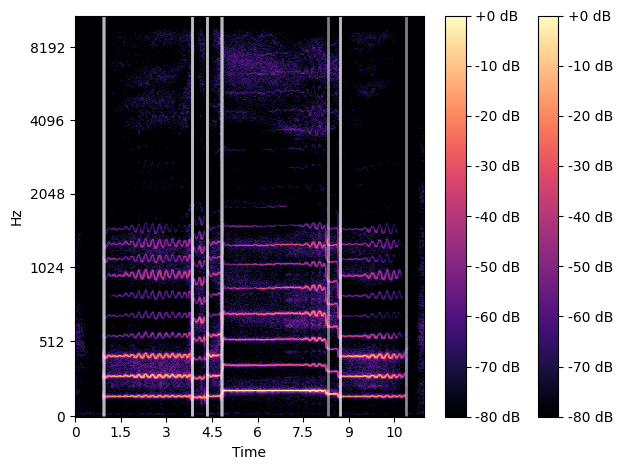

In [5]:
# load annotations from Sonic Visualiser
avmTimeInsants = pd.read_csv('/content/toss2025/audio/sonicVisualiser/avm_timeInstants.csv',names=['Time','Label'])
avmRegions = pd.read_csv('/content/toss2025/audio/sonicVisualiser/avm_regions.csv',names=['Time','Dummy','Offset','Label'])

# plot Sonic Visualiser onset estimates over spectrogram (Time Instants)
plotTimePoints(D,fs,avmTimeInsants['Time'])

# plot Sonic Visualiser onset estimates over spectrogram (Regions)
plotTimePoints(D,fs,avmRegions['Time'])


## Import and plot manual annotations from **Audacity**

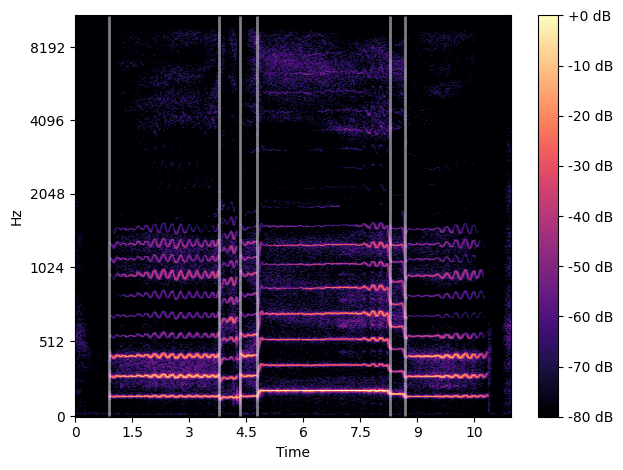

In [6]:
# load manual annotationsfrom Sonic Visualiser
avmAudacity = pd.read_table('/content/toss2025/audio/audacity/avm_audacityLabels.txt',names=['Time','Offset','Label'])

# plot Audacity annoatations over spectrogram
plotTimePoints(D,fs,avmAudacity['Time'])

## Import and plot manual annotations from **Tony**

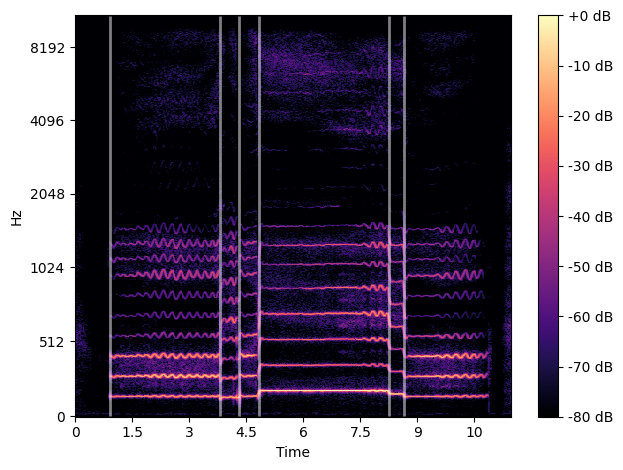

In [7]:
# load manual annotationsfrom Sonic Visualiser
avmTony = pd.read_table('/content/toss2025/audio/tony/avm_tonyLabels.txt',names=['Time','Offset','Label'])

# plot Audacity annoatations over spectrogram
plotTimePoints(D,fs,avmTony['Time'])

# Note-level descriptors

## Index into F0 estimates for each note and calculate the mean

In [8]:
# estiamte F0 with librosa
f0, voiced_flag, voiced_probs = librosa.pyin(y,sr=fs, frame_length=2048, win_length=256,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0)
avmF0librosa = pd.DataFrame()
avmF0librosa['Time'] = times
avmF0librosa['Data'] = f0

# calcaulate the mean F0 for each note in the Audacity annotations
noteF0vals = []
noteF0mean = []
for i in range(6):
  idx1 = (np.abs(avmF0librosa['Time'] - avmAudacity['Time'][i])).argmin()
  idx2 = (np.abs(avmF0librosa['Time'] - avmAudacity['Offset'][i])).argmin()
  noteF0vals.append(avmF0librosa['Data'][idx1:idx2])
  noteF0mean.append(np.mean(noteF0vals[i]))
print(noteF0mean)

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The win_length parameter has been deprecated in version 0.11.0 and has no effect. It will be removed in version 1.0.0.
  exec(code_obj, self.user_global_ns, self.user_ns)


[np.float64(456.25320741683385), np.float64(438.8384091235793), np.float64(460.28858993422875), np.float64(579.9750596104087), np.float64(506.85535237893845), np.float64(454.90600973892737)]


# Exercise: Calculate Spectral Centroid and calculate the mean value for each note

In [9]:
# estimate Spectral Centroid with librosa
# https://librosa.org/doc/0.11.0/generated/librosa.feature.spectral_centroid.html
specCent = librosa.feature.spectral_centroid(y=y, sr=fs)

times = librosa.times_like(specCent)

avmSClibrosa = pd.DataFrame()
avmSClibrosa['Time'] = times
avmSClibrosa['Data'] = specCent.T

In [10]:
# calcaulate the mean spectral centroid for each note in the Audacity annotations
